#Proyecto ROBOT TRADING V1.0

## 1. Configuración del Ambiente

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
global df_bitcoin
global precioactual
global tendencia
global media_bitcoin
global algoritmo_decision


In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.0.3
------
Name: numpy
Version: 1.25.2
------
Name: matplotlib
Version: 3.7.1


## 2. Obtención de datos

### Precios Históricos del Bitcoin

In [ ]:
def importar_base_bitcoin():
  import yfinance as yf
  global df_bitcoin
  bitcoin = yf.Ticker("BTC-USD")
  df_bitcoin = bitcoin.history(period="7d", interval="5m")


In [ ]:
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-04-05 00:00:00+00:00,68520.156250,68520.156250,68396.218750,68396.218750,0,0.0,0.0
2024-04-05 00:05:00+00:00,68381.718750,68389.062500,68369.156250,68374.140625,0,0.0,0.0
2024-04-05 00:10:00+00:00,68383.945312,68385.531250,68373.039062,68385.531250,0,0.0,0.0
2024-04-05 00:15:00+00:00,68371.421875,68379.617188,68291.687500,68291.687500,8736768,0.0,0.0
2024-04-05 00:20:00+00:00,68292.117188,68292.117188,68244.648438,68274.476562,0,0.0,0.0


### Indicadores de Tendencia

In [ ]:
from re import findall
from os import replace
from bs4 import BeautifulSoup
import requests
global valores
global precios_1h_

def extraer_tendencias():
  global valores
  global tendencia
  global precioactual
  global precios_1h_
  url = 'https://coinmarketcap.com/'
  page = requests.get(url)
  soup = BeautifulSoup(page.text, 'html')

# Extraer los datos de cada sección
  nombres = [nombre.text for nombre in soup.find_all('p', class_='sc-4984dd93-0 kKpPOn')]
  precios_actuales = [precio.text for precio in soup.find_all('div', {'class':['sc-500f568e-0 ejtlWy','sc-500f568e-0 ejtlWy rise','sc-500f568e-0 ejtlWy fall']})]
  precios_1h = [precio.text for precio in soup.find_all('span', {'class':['sc-6a54057-0']})][:10]

  #Coloco los valores a la variable Data, los paso a un Dataframe y transformo las variables numéricas a float.
  Data = {'Nombre': nombres, 'Precio Actual': precios_actuales, 'Precio 1h %': precios_1h}
  Data = pd.DataFrame(Data)
  Data['Precio Actual'] = Data['Precio Actual'].str.replace('$', '').str.replace(',', '').astype(float)
  Data['Precio 1h %'] = Data['Precio 1h %'].str.replace('%', '').astype(float)

  #busco la clase del ínoco de tendencia alta o baja.
  elementos_span = soup.find_all('span', class_='sc-6a54057-0')

  lista_tendencia = []

  for span in elementos_span:
      # Encontrar el elemento span dentro del elemento principal
      icono_span = span.find('span', class_=lambda value: value and ('icon-Caret-up' in value or 'icon-Caret-down' in value))

      # Si se encuentra el elemento span
      if icono_span:
          # Agregar la clase a la lista
          lista_tendencia.append(icono_span['class'][0])

  lista_tendencia = pd.DataFrame(lista_tendencia[:10], columns=['Tendencia']).replace('icon-Caret-down', 'Baja').replace('icon-Caret-up', 'Alta')

  Data = Data.join(lista_tendencia)

  valores = Data
  precioactual = valores['Precio Actual'][0]
  precios_1h_ = valores['Precio 1h %']
  tendencia = valores['Tendencia'][0]



In [ ]:
extraer_tendencias()
print('Precio del Bitcoin: ', precioactual)
print('Tendencia: ', tendencia)

Precio del Bitcoin:  70797.06
Tendencia:  Alta


## 3. Limpieza de Datos

In [ ]:
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1792 entries, 2024-04-05 00:00:00+00:00 to 2024-04-11 05:15:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1792 non-null   float64
 1   High          1792 non-null   float64
 2   Low           1792 non-null   float64
 3   Close         1792 non-null   float64
 4   Volume        1792 non-null   int64  
 5   Dividends     1792 non-null   float64
 6   Stock Splits  1792 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 112.0 KB
None


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1792.0,1792.0,1792.0,1792.0,1.792000e+03,1792.0,1792.0
mean,69286.0,69326.0,69243.0,69284.0,3.195581e+07,0.0,0.0
std,1403.0,1403.0,1402.0,1402.0,6.662067e+07,0.0,0.0
min,66140.0,66294.0,66069.0,66069.0,0.000000e+00,0.0,0.0
25%,68065.0,68108.0,68031.0,68064.0,0.000000e+00,0.0,0.0
50%,69250.0,69283.0,69217.0,69250.0,2.293760e+06,0.0,0.0
75%,70235.0,70287.0,70167.0,70242.0,3.553638e+07,0.0,0.0
max,72669.0,72676.0,72565.0,72571.0,1.054018e+09,0.0,0.0


<Axes: >

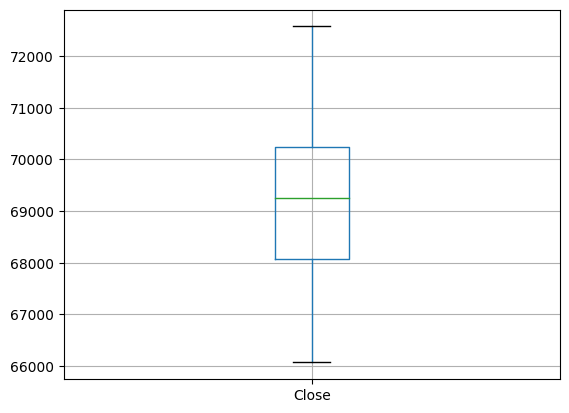

In [ ]:
df_bitcoin.boxplot(['Close'])

Antes de limpiar la base, crea una copia de la base df_bitcoin para que realices la limpieza en esta nueva base(df_bitcoin_limpio),

In [ ]:
df_bitcoin_limpio = df_bitcoin.copy()

Analiza la base df_bitcoin_limpio, identifica duplicados en el índice y trátalos para quedarte con sólo índices únicos.

In [ ]:
len(df_bitcoin_limpio)

1792

In [ ]:
# el índice no se repite. tiene el mismo numero de uniques que el número de registros del df = 1687
df_bitcoin_limpio.index.unique()

DatetimeIndex(['2024-04-05 00:00:00+00:00', '2024-04-05 00:05:00+00:00',
               '2024-04-05 00:10:00+00:00', '2024-04-05 00:15:00+00:00',
               '2024-04-05 00:20:00+00:00', '2024-04-05 00:25:00+00:00',
               '2024-04-05 00:30:00+00:00', '2024-04-05 00:35:00+00:00',
               '2024-04-05 00:40:00+00:00', '2024-04-05 00:45:00+00:00',
               ...
               '2024-04-11 04:30:00+00:00', '2024-04-11 04:35:00+00:00',
               '2024-04-11 04:40:00+00:00', '2024-04-11 04:45:00+00:00',
               '2024-04-11 04:50:00+00:00', '2024-04-11 04:55:00+00:00',
               '2024-04-11 05:00:00+00:00', '2024-04-11 05:05:00+00:00',
               '2024-04-11 05:10:00+00:00', '2024-04-11 05:15:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=1792, freq=None)

Luego busca por valores nulos en la columna Close y trátalos.

In [ ]:
# Se comprueba que no hay valores nulos en la columna Close
df_bitcoin_limpio['Close'].isnull().sum()

0

Verifica que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrário, elimínalos.

In [ ]:
#El nuevo DataFrame Limpio tendría 850 registros, quiere decir que se eliminarían 837 registros cuyo volumen de transación de ese momento era igual a 0.
len(df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0])

931

In [ ]:
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

Deberás identificar y eliminar los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot para identificarlos.

<Axes: >

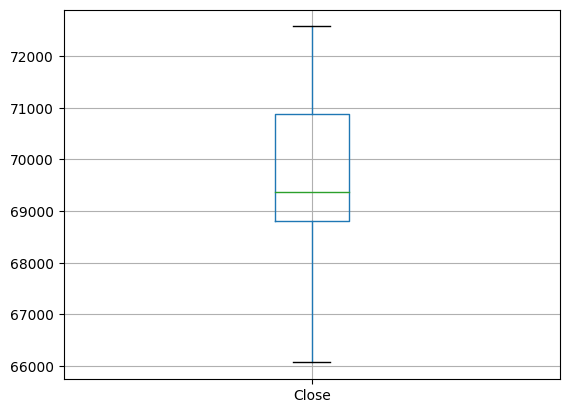

In [ ]:
#Boxplot del df limpio para el parámetro Close
df_bitcoin_limpio.boxplot('Close')

Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.

Finalmente, calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin.

In [ ]:
def limpieza_datos():
    global df_filtrado
    global media_bitcoin

    # Calcular el primer y tercer cuartil de la columna Close
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

    df_filtrado = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

    media_bitcoin = df_filtrado['Close'].mean()



<Axes: >

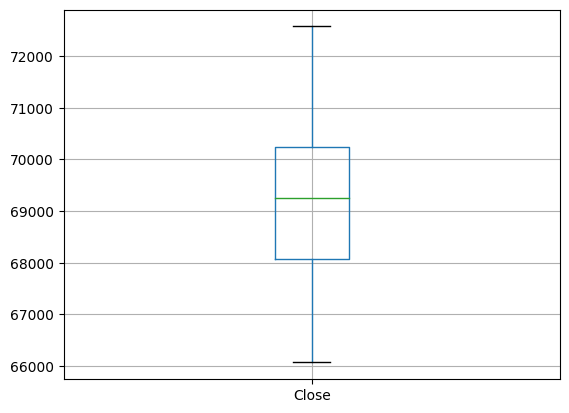

In [ ]:
df_bitcoin.boxplot(['Close'])

68816.3984375
70882.62890625


<Axes: >

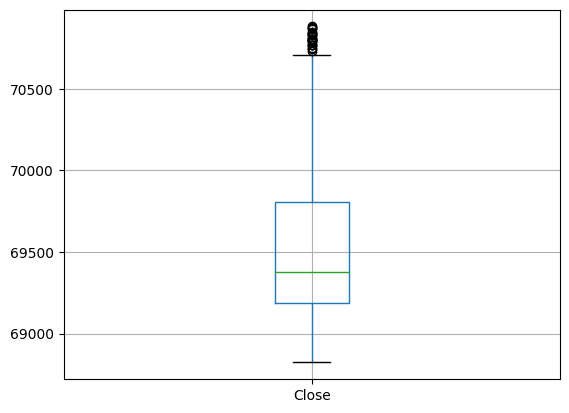

In [ ]:
limpieza_datos()
df_filtrado.boxplot(['Close'])

Calcular el promedio de Close

In [ ]:
print('El promedio del Bitcoin es: ',media_bitcoin.round(2))

El promedio del Bitcoin es:  69563.89


## 4. Tomar Decisiones

Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor 'Esperar'.

In [ ]:
def tomar_decision():
    global algoritmo_decision
    global precioactual
    global media_bitcoin
    # sólo si el precio actual es mayor que la media y la tendencia es a la baja, entonces se recomienda vender
    if precioactual >= media_bitcoin and tendencia == 'Baja':
        algoritmo_decision = 'Vender'
    #por el contrario si el precio actual es menor que la media y la tendencia es alta, entonces se recomienda comprar
    elif precioactual < media_bitcoin and tendencia == 'Alta':
        algoritmo_decision = 'Comprar'
    #cualquier otra cosa se espera
    else:
        algoritmo_decision = 'Esperar'


In [ ]:
tomar_decision()
print('Precio Promedio Bitcoin: ', media_bitcoin)
print('Precio Actual Bitcoin: ', precioactual)
print('Tendencia: ', tendencia)
print('Decisión del Algoritmo: ', algoritmo_decision)

Precio Promedio Bitcoin:  69563.88818884408
Precio Actual Bitcoin:  70724.33
Tendencia:  Alta
Decisión del Algoritmo:  Esperar


In [ ]:
print('Valores actuales de las criptos: ')
valores

Valores actuales de las criptos: 


,Nombre,Precio Actual,Precio 1h %,Tendencia
0,Bitcoin,70598.8700,0.21,Alta
1,Ethereum,3566.8400,1.81,Alta
2,Tether USDt,1.0000,7.74,Alta
3,BNB,612.9100,0.20,Alta
4,Solana,173.8000,1.12,Alta
5,XRP,0.6197,8.34,Alta
6,USDC,1.0000,0.00,Alta
7,Dogecoin,0.1965,0.05,Alta
8,Toncoin,7.4800,0.02,Alta
9,Cardano,0.5868,0.48,Baja


## 5. Visualización

Crea una funcion visualizacion(), dentro de ella, define nuevamente las variables globales(ver Paso1) y escribe tu código:

Adiciona una nueva columna (Promedio) al dataframe original df_bitcoiny almacena el valor de nuestra variable media_bitcoin.

In [ ]:
def visualizacion():
  global tendencia
  global precioactual
  global media_bitcoin

  #Adiciona una nueva columna (Promedio) al dataframe original df_bitcoiny almacena el valor de nuestra variable media_bitcoin.
  df_bitcoin['Promedio'] = media_bitcoin

  #Configura el tamaño del gráfico en una proporción de 16x5.
  plt.figure(figsize=(16,5))

  #Adiciona un t ítulo al gráfico.
  plt.title('Evolución Temporal del Precio del Bitcoin con Precio Promedio')

  #Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Close'])

 # Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'])

#Usando el método annotate()muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.
  x_coord = df_bitcoin.index[2]  # Coordenada x
  y_coord = 72000 # Coordenada y

# Anotar el mensaje en el gráfico
  plt.annotate('Se sugiere: {}'.format(algoritmo_decision), xy=(x_coord, y_coord), fontsize=12)

  plt.show()



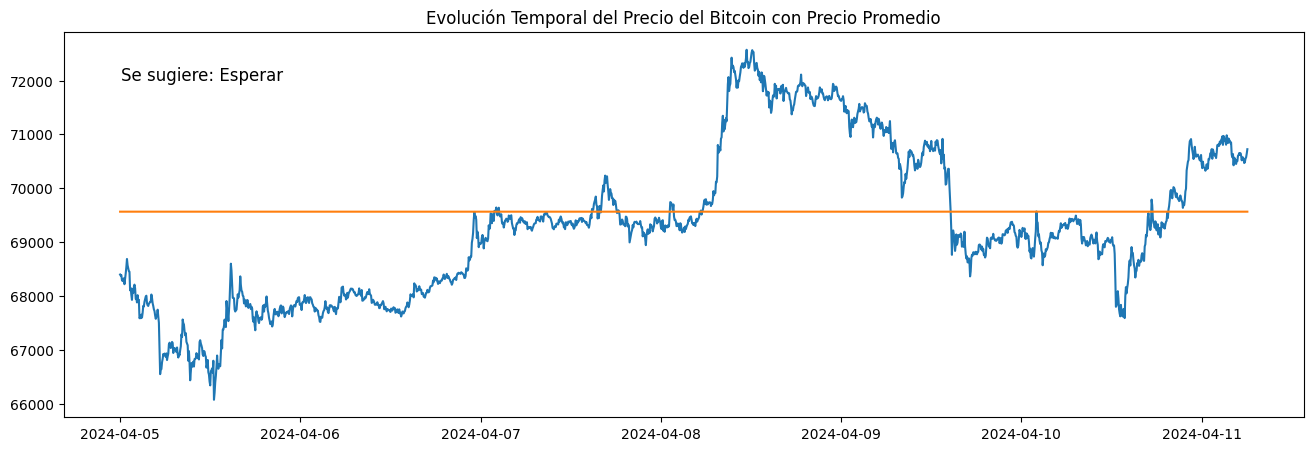

In [ ]:
visualizacion()

## 6. Automatización

In [ ]:
from IPython.display import clear_output

In [ ]:
import time

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decision()
  visualizacion()
  time.sleep(300)
